### Atelier de génération des images à partir d'une description textuelle

- diffusers : bibliothèque pour travailler avec des modèles de diffusion, comme Stable Diffusion.
- transformers : bibliothèque de Hugging Face pour les modèles de traitement du langage naturel.
- scipy et ftfy : bibliothèques utilitaires pour le traitement scientifique et la correction de texte.
- ipywidgets : pour créer des interfaces interactives dans Jupyter Notebook.
- streamlit : pour créer des applications web interactives basées sur Python.

In [ ]:
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

^C
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.32.1
    Uninstalling diffusers-0.32.1:
      Successfully uninstalled diffusers-0.32.1


In [2]:
pip install streamlit

In [3]:
import os
from PIL import Image, ImageDraw  #* pour le traitement d'images.
import cv2   #* pour les opérations de vision par ordinateur.
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch   #* bibliothèque PyTorch pour le calcul tensoriel et l'apprentissage profond.
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL #* : Fournit des outils pour gérer les modèles de diffusion
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer #* Encodent les textes en représentations vectorielles utilisées par le modèle.
from tqdm.auto import tqdm
from google.colab import output
device = 'cuda'

#output.enable_custom_widget_manager()
#notebook_login()

In [4]:
from huggingface_hub import notebook_login
output.enable_custom_widget_manager()
notebook_login()

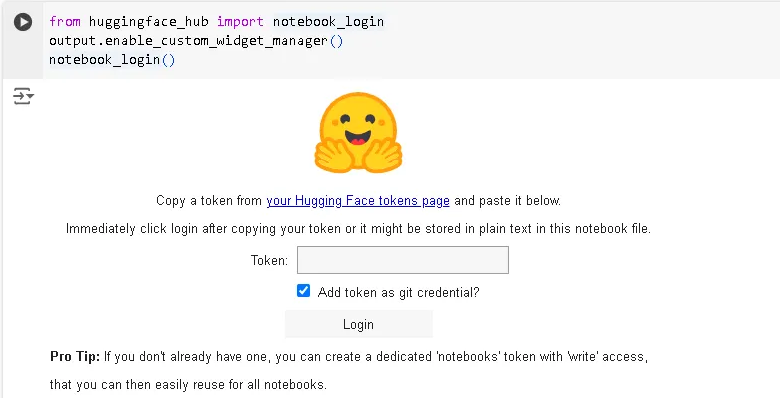

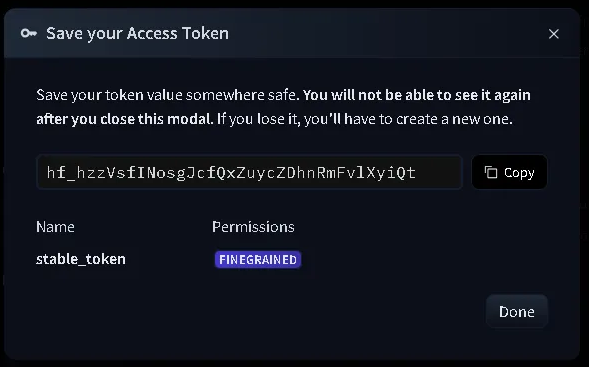

In [3]:
from IPython.display import Image, display

# Afficher une image depuis un chemin local
display(Image(filename="C:\\Users\\user\\Downloads\\img.png"))
display(Image(filename="C:\\Users\\user\\Downloads\\imga.png"))

In [5]:
# #! Configuration du périphérique
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
#* Configure le périphérique d'exécution (GPU ou CPU) pour accélérer les calculs.

Using device: cpu


In [6]:
# 1. Load the autoencoder model which will be used to decode the latents into image space.
#? Autoencodeur : utilisé pour décoder les latents en espace d'image
vae = AutoencoderKL.from_pretrained( #!  Il permet de reconstruire des images à partir de la représentation latente.
    'CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=False)

vae = vae.to(device)

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
#? Tokeniseur et encodeur de texte : pour transformer les descriptions textuelles en embeddings.
#? CLIP convertit les descriptions textuelles en vecteurs pour permettre au modèle de comprendre les instructions textuelles.
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14') #! transformer des chaînes de texte en identifiants numériques.
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')#! Transforme ces identifiants en embeddings
text_encoder = text_encoder.to(device)

# 3. The UNet model for generating the latents.
#? UNet est un modèle génératif utilisé pour produire des représentations latentes à partir de vecteurs textuels.
unet = UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='unet', use_auth_token=False).to(device)
#! UNet2DConditionModel: Ce modèle génère les latents à partir des embeddings de texte.

# 4. Create a scheduler for inference
#? Définit la manière dont le bruit est ajouté et retiré des latents au cours de la génération
scheduler = LMSDiscreteScheduler( #! Gère le processus d'inférence en contrôlant comment les latents sont modifiés au fil du temps.
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/modeling_utils.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization

##### Fonction pour obtenir les embeddings de texte


In [7]:
# #! get_text_embeds: convertit les descriptions textuelles en embeddings,permet au modèle de comprendre le contenu des descriptions.
def get_text_embeds(prompts):
  # Tokenize text and get embeddings
  text_input = tokenizer(
      prompts, padding='max_length', max_length=tokenizer.model_max_length,
      truncation=True, return_tensors='pt')
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

  # Do the same for unconditional embeddings
  uncond_input = tokenizer(
      [''] * len(prompts), padding='max_length',
      max_length=tokenizer.model_max_length, return_tensors='pt')
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

  # Cat for final embeddings
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings

In [8]:
test_embeds = get_text_embeds(['cute dog'])
print(test_embeds)
print(test_embeds.shape)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],

        [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.4771, -0.4680,  0.0514,  ..., -0.1052, -0.4885,  0.0188],
         [-2.0088,  0.5783,  0.3972,  ..., -1.1441, -0.9926, -0.6557],
         ...,
         [-0.6084, -0.0921,  0.2035,  ...,  0.1636, -1.3557, -1.4459],
         [-0.6007, -0.0966,  0.2229,  ...,  0.1646, -1.3530, -1.4512],
         [-0.5907, -0.0834,  0.2733,  ...,  0.1987, -1.3098, -1.4578]]])
torch.Size([2, 77, 768])


- produce_latents: génère des latents à partir des embeddings de texte.
- Génère des latents (représentations compactes de l'image) à partir d'embeddings textuels via le UNet.

In [9]:
#* num_inference_steps: Nombre d'étapes d'inférence "plus d'étapes peuvent mener à des images de meilleure qualité"
#* guidance_scale: Contrôle la force de la condition de texte
#* latents: doit être un tensor de latents initial, généré si aucun n'est fourni.
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]

  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)['prev_sample']

  return latents

# test_latents = produce_latents(test_embeds)
# print(test_latents)
# print(test_latents.shape)

####  Décodage des latents en images
- Décode les latents générés par le UNet en images visibles via le VAE

In [10]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    imgs = vae.decode(latents)

  imgs = (imgs / 2 + 0.5).clamp(0, 1)
  imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
  imgs = (imgs * 255).round().astype('uint8')
  pil_images = [Image.fromarray(image) for image in imgs]
  return pil_images

# imgs = decode_img_latents(test_latents)
# imgs[0]

In [11]:
# #!Combine toutes les étapes pour générer des images à partir d'un texte donné.
def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None, num_images=1):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)

  # Img latents -> imgs
  imgs = decode_img_latents(latents)

  return imgs

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


0it [00:00, ?it/s]

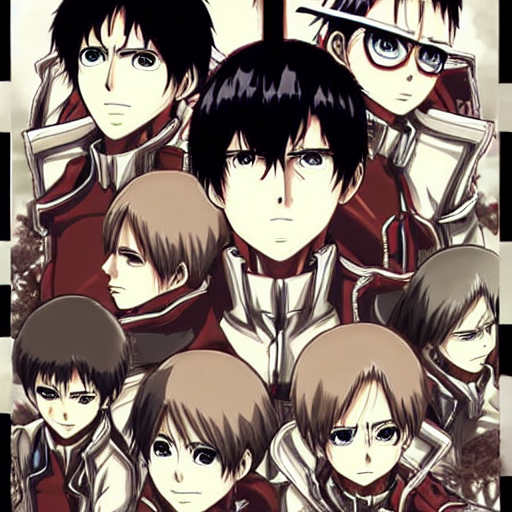

In [12]:
prompt_to_img('Super cool anime character attack on titan', 512, 512, 35)[0]

0it [00:00, ?it/s]

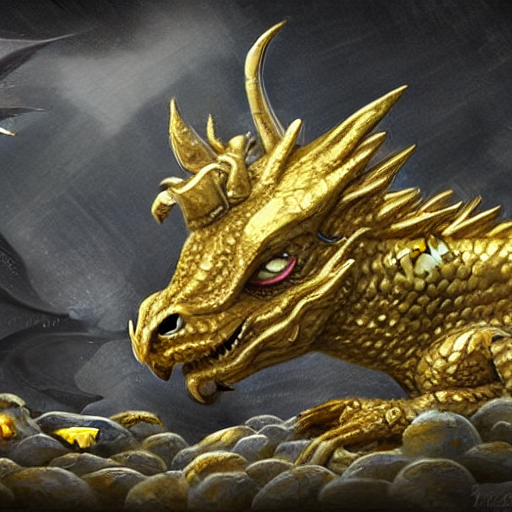

In [ ]:
prompt_to_img('A cute baby dragon sleeping on a pile of gold coins, fantasy art, highly detailed', 512, 512, 10)[0]

<ipython-input-25-b75a3f8e5f34>:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
9it [06:43, 44.81s/it]


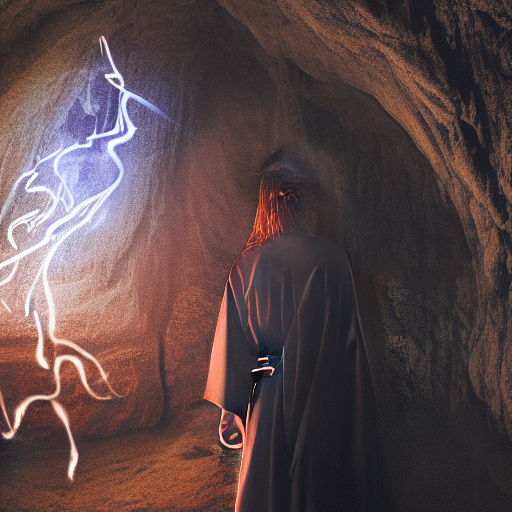

In [26]:
prompt_to_img('A mysterious sorcerer with a flowing robe, casting a spell with glowing runes, in a dark cave with magical light', 512, 512, 9)[0]

<ipython-input-25-b75a3f8e5f34>:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
20it [14:45, 44.26s/it]
13it [09:26, 43.57s/it]
16it [11:35, 43.44s/it]
22it [15:43, 42.89s/it]


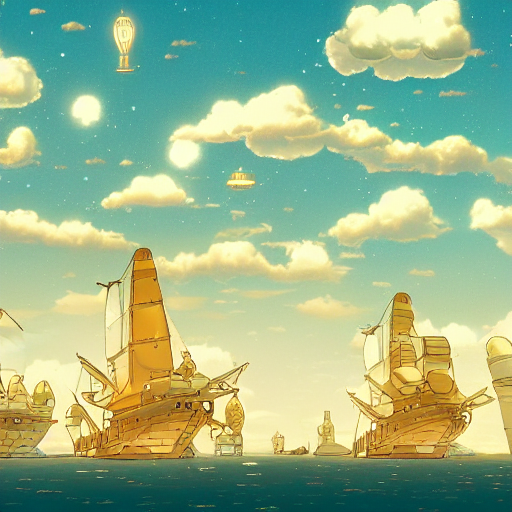

In [27]:
prompt_to_img('A majestic floating city in the clouds, glowing with golden light, surrounded by airships, in the style of Studio Ghibli', 512, 512, 22)[0]

<ipython-input-25-b75a3f8e5f34>:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
16it [11:57, 44.83s/it]


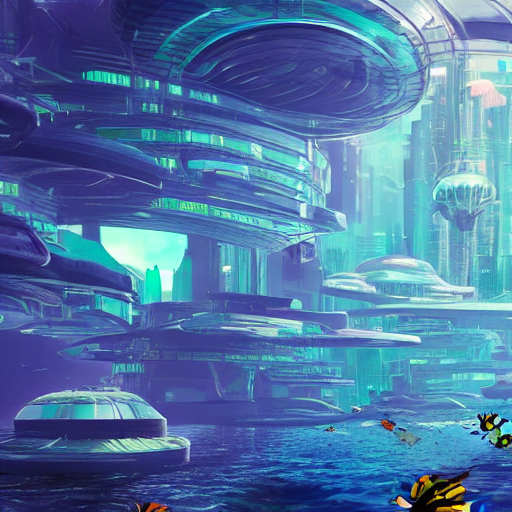

In [29]:
prompt_to_img('A futuristic underwater city with glass domes, colorful marine life swimming around, cyberpunk aesthetic', 512, 512, 16)[0]

<ipython-input-25-b75a3f8e5f34>:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
11it [07:54, 43.12s/it]


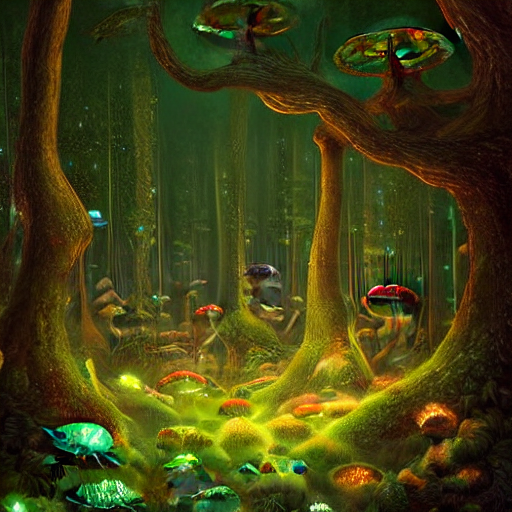

In [28]:
prompt_to_img('A serene forest with glowing mushrooms and bioluminescent plants at night, fantasy art, ultra-detailed', 512, 512, 11)[0]

In [13]:
import streamlit as st

Importation des bibliothéques
*   ipywidgets : Cette bibliothèque vous permet de créer des widgets interactifs dans les notebooks Jupyter. Les widgets, comme des sliders et des boutons, rendent l'interface utilisateur plus dynamique.
*   



Text(value='An ancient Greek temple on top of a mountain, surrounded by golden light, with Zeus standing in fr…

IntSlider(value=512, description='Hauteur:', max=1024, min=256, step=8)

IntSlider(value=512, description='Largeur:', max=1024, min=256, step=8)

IntSlider(value=50, description="Étapes d'inférence:", min=1)

FloatSlider(value=7.5, description='Échelle de guidance:', max=20.0, min=1.0)

IntSlider(value=1, description="Nombre d'images:", max=10, min=1)

Button(description="Générer l'image", style=ButtonStyle())

Génération d'images...


0it [00:00, ?it/s]

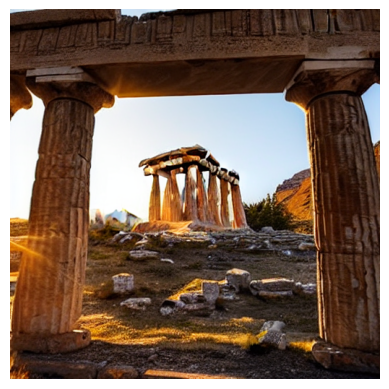

In [15]:
# Fonction pour s'assurer que les dimensions sont multiples de 8
def adjust_dimension(value):
    return (value // 8) * 8

# Widgets pour l'interface utilisateur
prompt_widget = widgets.Text(value="An ancient Greek temple on top of a mountain, surrounded by golden light, with Zeus standing in front of it", description='Prompt:')
height_widget = widgets.IntSlider(value=512, min=256, max=1024, step=8, description='Hauteur:')
width_widget = widgets.IntSlider(value=512, min=256, max=1024, step=8, description='Largeur:')
steps_widget = widgets.IntSlider(value=50, min=1, max=100, description='Étapes d\'inférence:')
guidance_widget = widgets.FloatSlider(value=7.5, min=1.0, max=20.0, step=0.1, description='Échelle de guidance:')
num_images_widget = widgets.IntSlider(value=1, min=1, max=10, description='Nombre d\'images:')

run_button = widgets.Button(description="Générer l'image")

# Fonction de génération d'image au clic du bouton
def on_button_click(b):
    with run_button.hold_trait_notifications():
        print("Génération d'images...")

        # Ajuster la hauteur et la largeur pour qu'elles soient des multiples de 8
        adjusted_height = adjust_dimension(height_widget.value)
        adjusted_width = adjust_dimension(width_widget.value)

        imgs = prompt_to_img(
            prompt_widget.value,
            height=adjusted_height,
            width=adjusted_width,
            num_inference_steps=steps_widget.value,
            guidance_scale=guidance_widget.value,
            num_images=num_images_widget.value
        )

        # Affichage des images
        for img in imgs:
            plt.imshow(img)
            plt.axis('off')  # Masquer les axes
            plt.show()

# Liaison de la fonction au bouton
run_button.on_click(on_button_click)

# Affichage des widgets
display(prompt_widget, height_widget, width_widget, steps_widget, guidance_widget, num_images_widget, run_button)


Text(value='A mysterious sorcerer with a flowing robe, casting a spell with glowing runes, in a dark cave with…

IntSlider(value=512, description='Hauteur:', max=1024, min=256, step=8)

IntSlider(value=512, description='Largeur:', max=1024, min=256, step=8)

IntSlider(value=50, description="Étapes d'inférence:", min=1)

FloatSlider(value=7.5, description='Échelle de guidance:', max=20.0, min=1.0)

IntSlider(value=1, description="Nombre d'images:", max=10, min=1)

Button(description="Générer l'image", style=ButtonStyle())

Génération d'images...


<ipython-input-25-b75a3f8e5f34>:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
10it [07:32, 45.29s/it]


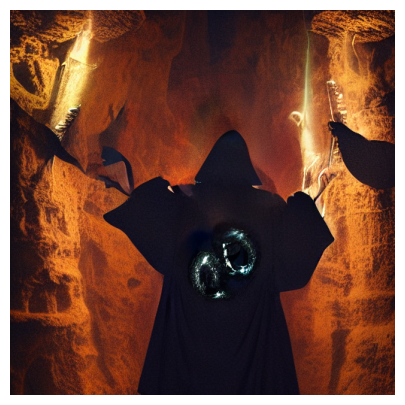

In [25]:
import torch
from torch.cuda.amp import autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

# Fonction pour s'assurer que les dimensions sont multiples de 8
def adjust_dimension(value):
    return (value // 8) * 8

# Widgets pour l'interface utilisateur
prompt_widget = widgets.Text(value="A mysterious sorcerer with a flowing robe, casting a spell with glowing runes, in a dark cave with magical light", description='Prompt:')
height_widget = widgets.IntSlider(value=512, min=256, max=1024, step=8, description='Hauteur:')
width_widget = widgets.IntSlider(value=512, min=256, max=1024, step=8, description='Largeur:')
steps_widget = widgets.IntSlider(value=50, min=1, max=100, description='Étapes d\'inférence:')
guidance_widget = widgets.FloatSlider(value=7.5, min=1.0, max=20.0, step=0.1, description='Échelle de guidance:')
num_images_widget = widgets.IntSlider(value=1, min=1, max=10, description='Nombre d\'images:')

run_button = widgets.Button(description="Générer l'image")

# Fonction de génération d'image au clic du bouton
def on_button_click(b):
    with run_button.hold_trait_notifications():
        print("Génération d'images...")

        # Ajuster la hauteur et la largeur pour qu'elles soient des multiples de 8
        adjusted_height = adjust_dimension(height_widget.value)
        adjusted_width = adjust_dimension(width_widget.value)

        imgs = prompt_to_img(
            prompt_widget.value,
            height=adjusted_height,
            width=adjusted_width,
            num_inference_steps=steps_widget.value,
            guidance_scale=guidance_widget.value,
            num_images=num_images_widget.value
        )

        # Affichage des images
        plt.figure(figsize=(15, 5))  # Ajuster la taille de la figure
        for i, img in enumerate(imgs):
            plt.subplot(1, len(imgs), i + 1)  # Créer un subplot pour chaque image
            plt.imshow(img)
            plt.axis('off')  # Masquer les axes
        plt.show()

# Liaison de la fonction au bouton
run_button.on_click(on_button_click)

# Affichage des widgets
display(prompt_widget, height_widget, width_widget, steps_widget, guidance_widget, num_images_widget, run_button)
def get_text_embeds(prompts):
    # Tokenize text and get embeddings
    text_input = tokenizer(
        prompts, padding='max_length', max_length=tokenizer.model_max_length,
        truncation=True, return_tensors='pt'
    )
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Do the same for unconditional embeddings
    uncond_input = tokenizer(
        [''] * len(prompts), padding='max_length',
        max_length=tokenizer.model_max_length, return_tensors='pt'
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Cat for final embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    return text_embeddings  # Assurez-vous que c'est un Tensor

def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None, num_images=1):
    if isinstance(prompts, str):
        prompts = [prompts]

    # Prompts -> text embeds
    text_embeds = get_text_embeds(prompts)

    # Créer des latents pour chaque image
    latents = produce_latents(
        text_embeds, height=height, width=width, latents=latents,
        num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)

    # Img latents -> imgs
    imgs = decode_img_latents(latents)

    return imgs

def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None):
    num_images = text_embeddings.shape[0] // 2  # Assurez-vous que c'est un Tensor
    if latents is None:
        latents = torch.randn((num_images, unet.in_channels, height // 8, width // 8))

    latents = latents.to(device)

    scheduler.set_timesteps(num_inference_steps)
    latents = latents * scheduler.sigmas[0]

    with torch.cuda.amp.autocast():
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # Expand the latents if we are doing classifier-free guidance
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # Predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # Compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, i, latents)['prev_sample']

    return latents


def decode_img_latents(latents):
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        imgs = vae.decode(latents)

    imgs = (imgs / 2 + 0.5).clamp(0, 1)
    imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
    imgs = (imgs * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in imgs]
    return pil_images